In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten
import scipy.stats as st
import math
import random

In [2]:
from ipynb.fs.defs.DifferentStations import prev_event, process_times, A_ii, A_ij, excitation_j, diff_comp, diff_log_likelihood, thres_fun, kappa_fun, ecdf, get_station_index

In [3]:
def hawkes_comp(t, times, beta, theta, lambda_b):
    ratio = beta/theta
    ind = prev_event(times, t)
    second_sum = 0
    
    if ind != 0:
        second_sum = ratio * np.sum(np.exp(-theta*(t - times[0:ind])) - 1)
    comp= lambda_b*t - second_sum 
    
    return comp

In [4]:
def hawkes_log_likelihood(times, beta, theta, lambda_b): 
    ratio = beta/theta
    A = np.zeros(len(times))
    T = times[-1]
    
    for i in range(1, len(times)):
        A[i] = np.exp(-theta*(times[i] - times[i-1]))*(1+A[i-1])
    
    first_sum = np.sum(np.log(lambda_b + beta*A))
    second_sum = ratio * np.sum(np.exp(-theta*(T - times)) - 1)
    res = first_sum + second_sum - lambda_b*T
    
    return res

In [5]:
station_data = pd.read_csv("./santander_locations.csv")
loc_codes = list(station_data['Station.Id'].to_numpy())
all_times = {}

for i in range(808):
    loc = loc_codes[i]
    path = f"./dep/Station{loc}"
    data_files = os.listdir(path)

    bike = {file: pd.read_csv(path + '/' + file)
             for file in data_files}  

    for names in bike.keys():
        del bike[names]["Unnamed: 0"]
    
    times = {}

    for names in bike.keys():
        if names != '.DS_Store':
            df = bike[names]
            df = df['start_t']
            times[names] = df.values.tolist()
    
    times_list = np.array(sorted(flatten(list(times.values()))))
    all_times[loc] = times_list
    
loc_codes0 = loc_codes

In [6]:
list(bike.keys())[0]

'235_07Oct2020-13Oct2020.csv'

In [7]:
station_data = pd.read_csv("./santander_locations.csv")
loc_codes = list(station_data['Station.Id'].to_numpy())
train_times = {}
test_times = {}

for i in range(808):
    loc = loc_codes[i]
    path = f"./sortdep/Station{loc}"
    data_files = os.listdir(path)

    bike = {file: pd.read_csv(path + '/' + file)
             for file in data_files}  

    for names in bike.keys():
        del bike[names]["Unnamed: 0"]
    
    train = {}
    test = {}
    week_list = list(bike.keys())
    n = len(week_list)
    
    for j in range(n):
        names = week_list[j]
        if names != '.DS_Store' and j < 12:
            df = bike[names]
            df = df['start_t']
            train[names] = df.values.tolist()
        elif names != '.DS_Store' and j >= 12:
            df = bike[names]
            df = df['start_t']
            test[names] = df.values.tolist()
             
    train_list = np.array(sorted(flatten(list(train.values()))))
    test_list = np.array(sorted(flatten(list(test.values()))))
    train_times[loc] = train_list
    test_times[loc] = test_list
    
loc_codes0 = loc_codes

In [8]:
geo_df= pd.read_csv('./geodesic.csv')
del geo_df["Unnamed: 0"]

dist_arr = np.zeros(len(loc_codes))

In [9]:
loc_codes = loc_codes0
len(dist_arr)

808

In [10]:
ks_train_hawkes = []
ks_test_hawkes = []
ks_train_spatio = []
ks_test_spatio = []

Victoria Station

Different stations

In [128]:
sid = 268
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

In [129]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

11
11
[148, 161, 167, 177, 178, 243, 268, 288, 320, 424, 826]


In [130]:
t00 = {}
t01 = {}

for loc in new_loc:
    t00[loc] = t0[loc]
    t01[loc] = t1[loc]

t00[268]

array([   394.06837819,    421.64216366,    429.84886557, ...,
       161060.65142088, 161062.39674381, 161121.55919642])

In [227]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-4, -3, -8, 1.6], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-3.84924511, -3.09005731, -8.45537374,  1.66464874],
       [-3.84922665, -3.09003794, -8.45528851,  1.66464125],
       [-3.84926822, -3.09005683, -8.45538095,  1.66463176],
       [-3.84921574, -3.09003521, -8.45542934,  1.66464875],
       [-3.84922875, -3.09006733, -8.45543148,  1.66465951]]), array([14571.40788557, 14571.40788557, 14571.40788558, 14571.40788563,
       14571.40788563]))
           fun: 14571.407885565552
       message: 'Optimization terminated successfully.'
          nfev: 195
           nit: 112
        status: 0
       success: True
             x: array([-3.84924511, -3.09005731, -8.45537374,  1.66464874])

In [228]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-3.84924253, -3.09005352, -8.45527972,  1.66464445],
       [-3.84925831, -3.09005258, -8.45535865,  1.66463708],
       [-3.84923082, -3.09005656, -8.45536212,  1.66465012],
       [-3.84924357, -3.09006298, -8.45528644,  1.66465147],
       [-3.84923746, -3.09002987, -8.45529987,  1.66463577]]), array([14571.40788553, 14571.40788555, 14571.40788555, 14571.40788556,
       14571.40788556]))
           fun: 14571.407885530845
       message: 'Optimization terminated successfully.'
          nfev: 394
           nit: 237
        status: 0
       success: True
             x: array([-3.84924253, -3.09005352, -8.45527972,  1.66464445])

In [224]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [225]:
ks0

KstestResult(statistic=0.0950903581843372, pvalue=3.573382465377084e-28)

In [218]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

In [219]:
ks1

KstestResult(statistic=0.27170645688688944, pvalue=1.990903278514121e-78)

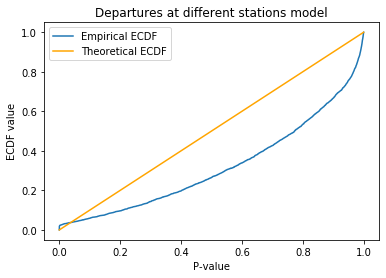

In [183]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0, label="Empirical ECDF")

plt.title("Departures at different stations model")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Different stations with large k

In [62]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-3, -8, -8], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.55237567, -39.98100424, -11.2378472 ],
       [ -4.55237567, -39.98095226, -11.2378472 ],
       [ -4.55237567, -39.98091893, -11.2378472 ],
       [ -4.55237567, -39.98095714, -11.2378472 ]]), array([11790.31262213, 11790.31262213, 11790.31262213, 11790.31262213]))
           fun: 11790.312622126603
       message: 'Optimization terminated successfully.'
          nfev: 368
           nit: 188
        status: 0
       success: True
             x: array([ -4.55237567, -39.98100424, -11.2378472 ])

In [63]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

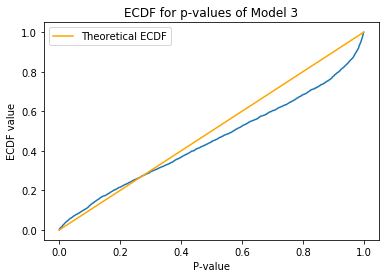

In [64]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Hawkes

In [151]:
t0 = train_times[268]
t1 = test_times[268]

In [220]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-4.08649944, -6.2881818 , -6.12060675],
       [-4.08650453, -6.28810564, -6.12060161],
       [-4.08649755, -6.28809629, -6.12057448],
       [-4.08648476, -6.28818211, -6.12060595]]), array([15114.06178121, 15114.06178124, 15114.06178126, 15114.06178129]))
           fun: 15114.06178121102
       message: 'Optimization terminated successfully.'
          nfev: 203
           nit: 115
        status: 0
       success: True
             x: array([-4.08649944, -6.2881818 , -6.12060675])

In [221]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [222]:
ks2.statistic

0.11060322830095759

In [154]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

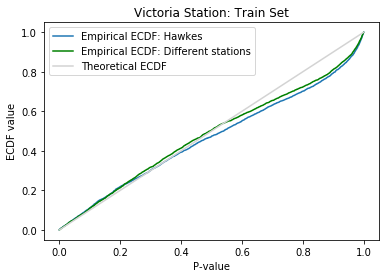

In [155]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')
plt.legend()
plt.show()

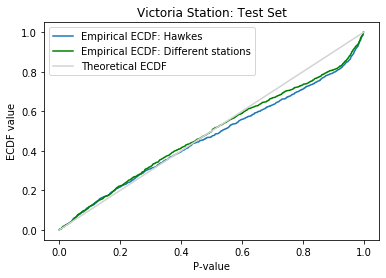

In [156]:
x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.plot(x21,y21,  label="Empirical ECDF: Hawkes")
plt.plot(x01,y01,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')
plt.legend()
plt.show()

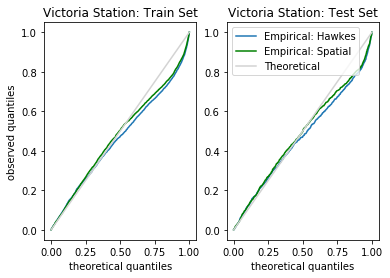

In [157]:
x2,y2 = ecdf(p_values2)
plt.subplot(1, 2, 1)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("theoretical quantiles")
plt.ylabel("observed quantiles")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')



x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.subplot(1, 2, 2)
plt.plot(x21,y21,  label="Empirical: Hawkes")
plt.plot(x01,y01,  label="Empirical: Spatial", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("theoretical quantiles")
plt.plot([0,1], [0,1], label="Theoretical", color='lightgray')
plt.legend()

plt.show()


Waterloo Station

Different stations

In [266]:
sid = 374
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

In [267]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

14
14
[154, 173, 197, 252, 272, 273, 334, 336, 347, 361, 374, 377, 815, 819]


In [268]:
t00 = {}
t01 = {}

for loc in new_loc:
    t00[loc] = t0[loc]
    t01[loc] = t1[loc]
    
t00.keys()

dict_keys([154, 173, 197, 252, 272, 273, 334, 336, 347, 361, 374, 377, 815, 819])

In [158]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-4, -3, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-3.84926669, -3.09007511, -8.45537375,  1.66464124],
       [-3.84920263, -3.09003322, -8.45534507,  1.66465546],
       [-3.849242  , -3.09008676, -8.45541233,  1.66466425],
       [-3.84923558, -3.0900144 , -8.45542272,  1.66462596],
       [-3.84924283, -3.09007275, -8.45546357,  1.66464788]]), array([14571.40788558, 14571.40788563, 14571.40788567, 14571.40788569,
       14571.40788571]))
           fun: 14571.40788558111
       message: 'Optimization terminated successfully.'
          nfev: 456
           nit: 268
        status: 0
       success: True
             x: array([-3.84926669, -3.09007511, -8.45537375,  1.66464124])

In [270]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [271]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

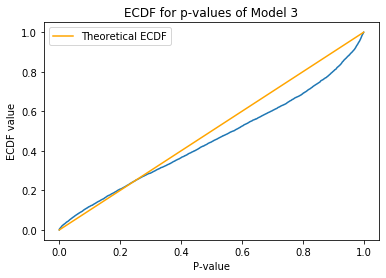

In [94]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Different stations with large k

In [99]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.4600117 ,  -3.89546789, -10.62337822],
       [ -4.46000851,  -3.89545638, -10.62344389],
       [ -4.46002638,  -3.8954701 , -10.62340859],
       [ -4.45999775,  -3.89544542, -10.62330309]]), array([24148.18059898, 24148.18059907, 24148.1805992 , 24148.1805992 ]))
           fun: 24148.180598984636
       message: 'Optimization terminated successfully.'
          nfev: 168
           nit: 92
        status: 0
       success: True
             x: array([ -4.4600117 ,  -3.89546789, -10.62337822])

In [100]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

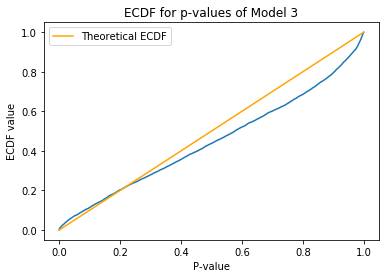

In [101]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Hawkes

In [272]:
t0 = train_times[374]
t1 = test_times[374]

In [273]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.67249437, -8.0500733 , -9.23636648],
       [-3.6724928 , -8.05014571, -9.23637637],
       [-3.67249399, -8.05016234, -9.23636872],
       [-3.67249621, -8.05007101, -9.23638705]]), array([24655.08221933, 24655.08221933, 24655.08221933, 24655.08221934]))
           fun: 24655.082219332613
       message: 'Optimization terminated successfully.'
          nfev: 287
           nit: 166
        status: 0
       success: True
             x: array([-3.67249437, -8.0500733 , -9.23636648])

In [274]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [275]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

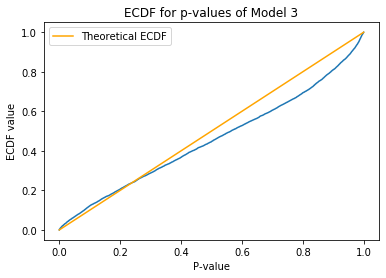

In [276]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

NameError: name 'x0' is not defined

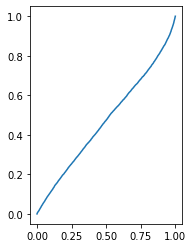

In [36]:
x2,y2 = ecdf(p_values2)
plt.subplot(1, 2, 1)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("theoretical quantiles")
plt.ylabel("observed quantiles")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')



x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.subplot(1, 2, 2)
plt.plot(x21,y21,  label="Empirical: Hawkes")
plt.plot(x01,y01,  label="Empirical: Spatial", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("theoretical quantiles")
plt.plot([0,1], [0,1], label="Theoretical", color='lightgray')
plt.legend()

plt.show()
plt.savefig('vic1.pdf')

Paddington Station

Different stations

In [278]:
sid = 186
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

In [279]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[186, 265, 279, 290, 330, 370, 408]


In [280]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

In [281]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -3.85746826,  -3.99937713, -10.45439721,   1.3533935 ],
       [ -3.8574779 ,  -3.99937963, -10.45436746,   1.35339949],
       [ -3.85746976,  -3.99934598, -10.45447989,   1.3533829 ],
       [ -3.85749443,  -3.99940759, -10.45449561,   1.35339833],
       [ -3.85746423,  -3.99941385, -10.45446345,   1.35343002]]), array([20960.79889313, 20960.79889316, 20960.79889331, 20960.79889333,
       20960.79889334]))
           fun: 20960.798893131294
       message: 'Optimization terminated successfully.'
          nfev: 787
           nit: 466
        status: 0
       success: True
             x: array([ -3.85746826,  -3.99937713, -10.45439721,   1.3533935 ])

In [282]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [283]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

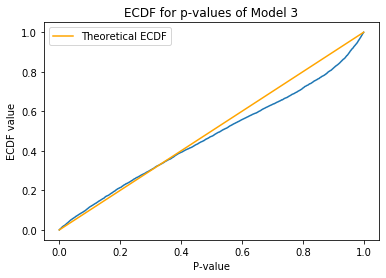

In [284]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Different stations with large k

In [143]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[-3.98398511, -8.36833696, -9.44918038],
       [-3.98398713, -8.36826141, -9.44917018],
       [-3.98398428, -8.36839508, -9.44917836],
       [-3.98398443, -8.36825676, -9.44917483]]), array([21467.0443917, 21467.0443917, 21467.0443917, 21467.0443917]))
           fun: 21467.044391700347
       message: 'Optimization terminated successfully.'
          nfev: 227
           nit: 126
        status: 0
       success: True
             x: array([-3.98398511, -8.36833696, -9.44918038])

In [144]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

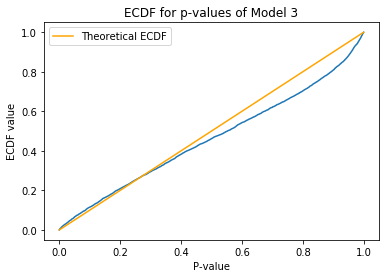

In [145]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Hawkes

In [146]:
t0 = train_times[186]
t1 = test_times[186]

In [147]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.98398511, -8.36833696, -9.44918038],
       [-3.98398713, -8.36826141, -9.44917018],
       [-3.98398428, -8.36839508, -9.44917836],
       [-3.98398443, -8.36825676, -9.44917483]]), array([21467.0443917, 21467.0443917, 21467.0443917, 21467.0443917]))
           fun: 21467.044391700347
       message: 'Optimization terminated successfully.'
          nfev: 227
           nit: 126
        status: 0
       success: True
             x: array([-3.98398511, -8.36833696, -9.44918038])

In [148]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [149]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

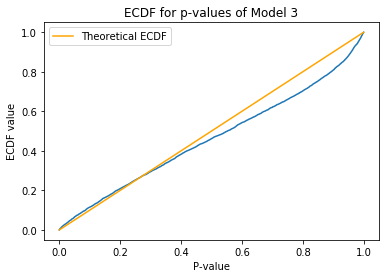

In [150]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

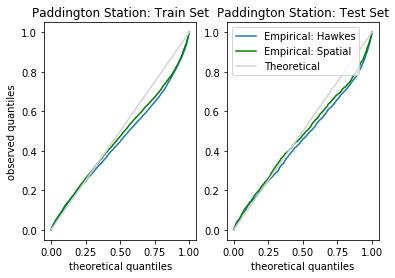

In [286]:
x2,y2 = ecdf(p_values2)
plt.subplot(1, 2, 1)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Paddington Station: Train Set")
plt.xlabel("theoretical quantiles")
plt.ylabel("observed quantiles")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')



x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.subplot(1, 2, 2)
plt.plot(x21,y21,  label="Empirical: Hawkes")
plt.plot(x01,y01,  label="Empirical: Spatial", color='green')

plt.title("Paddington Station: Test Set")
plt.xlabel("theoretical quantiles")
plt.plot([0,1], [0,1], label="Theoretical", color='lightgray')
plt.legend()

plt.show()

London Bridge

Different stations

In [151]:
sid = 706
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

In [153]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[85, 269, 278, 308, 314, 321, 706]


In [155]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

In [156]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -4.4362979 , -41.98665806, -11.22718008,  19.32658707],
       [ -4.4362979 , -41.98662429, -11.22718008,  19.32657299],
       [ -4.4362979 , -41.9865791 , -11.22718008,  19.32655414],
       [ -4.4362979 , -41.98657748, -11.22718008,  19.32655347],
       [ -4.4362979 , -41.98661365, -11.22718008,  19.32656855]]), array([13821.59784233, 13821.59784233, 13821.59784233, 13821.59784233,
       13821.59784233]))
           fun: 13821.597842327441
       message: 'Optimization terminated successfully.'
          nfev: 505
           nit: 272
        status: 0
       success: True
             x: array([ -4.4362979 , -41.98665806, -11.22718008,  19.32658707])

In [157]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [158]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

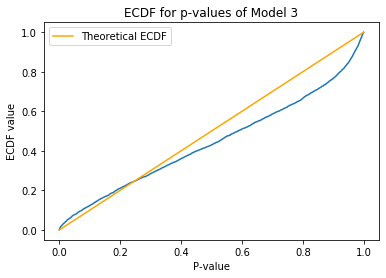

In [159]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Different stations with large k

In [160]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.43629791, -41.74076084, -11.22718052],
       [ -4.43629791, -41.7407555 , -11.22718052],
       [ -4.43629791, -41.74081133, -11.22718052],
       [ -4.43629791, -41.74066822, -11.22718052]]), array([13821.59784233, 13821.59784233, 13821.59784233, 13821.59784233]))
           fun: 13821.597842327441
       message: 'Optimization terminated successfully.'
          nfev: 415
           nit: 213
        status: 0
       success: True
             x: array([ -4.43629791, -41.74076084, -11.22718052])

In [161]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

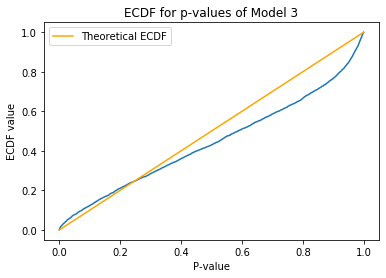

In [162]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Hawkes

In [23]:
t0 = train_times[374]
t1 = test_times[374]

In [24]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.41664096, -5.8208873 , -5.58208767],
       [-3.41663699, -5.82081447, -5.58202901],
       [-3.41665628, -5.82084473, -5.58207623],
       [-3.41663313, -5.82096595, -5.58204468]]), array([24293.8122462 , 24293.81224629, 24293.81224638, 24293.81224647]))
           fun: 24293.812246195273
       message: 'Optimization terminated successfully.'
          nfev: 170
           nit: 92
        status: 0
       success: True
             x: array([-3.41664096, -5.8208873 , -5.58208767])

In [25]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [26]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

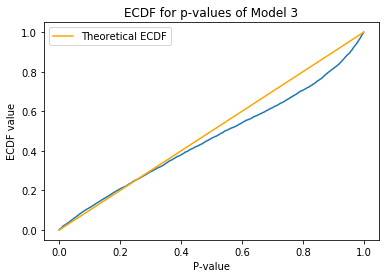

In [27]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

King's Cross

Different stations

In [171]:
sid = 798
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

In [172]:
thres = 0.4
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

6
6
[4, 14, 70, 593, 793, 798]


In [173]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

In [174]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -4.53545008, -38.78045598, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78053173, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78048089, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78053717, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78052346, -12.61983584,   3.96486705]]), array([11863.14876305, 11863.14876305, 11863.14876305, 11863.14876305,
       11863.14876305]))
           fun: 11863.148763053616
       message: 'Optimization terminated successfully.'
          nfev: 698
           nit: 397
        status: 0
       success: True
             x: array([ -4.53545008, -38.78045598, -12.61983584,   3.96486705])

In [175]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [176]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

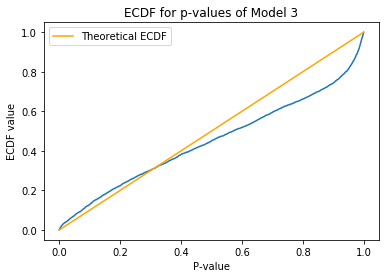

In [177]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Different stations with large k

In [178]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.63479887, -39.92813714, -12.02759482],
       [ -4.63479887, -39.92812801, -12.02759482],
       [ -4.63479887, -39.9280819 , -12.02759482],
       [ -4.63479887, -39.92806304, -12.02759482]]), array([11870.00028289, 11870.00028289, 11870.00028289, 11870.00028289]))
           fun: 11870.000282890436
       message: 'Optimization terminated successfully.'
          nfev: 564
           nit: 305
        status: 0
       success: True
             x: array([ -4.63479887, -39.92813714, -12.02759482])

In [179]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

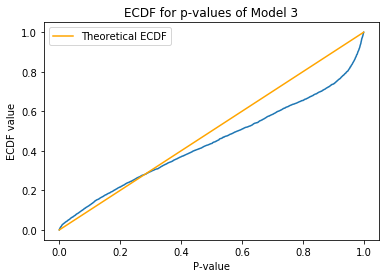

In [180]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Hawkes

In [28]:
t0 = train_times[798]
t1 = test_times[798]

In [29]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.9860596 , -5.55193327, -5.5868416 ],
       [-3.98609729, -5.55201033, -5.58686599],
       [-3.9860798 , -5.55199569, -5.58680566],
       [-3.98608469, -5.55195203, -5.58678707]]), array([15212.88216185, 15212.88216189, 15212.88216197, 15212.88216219]))
           fun: 15212.882161853535
       message: 'Optimization terminated successfully.'
          nfev: 257
           nit: 146
        status: 0
       success: True
             x: array([-3.9860596 , -5.55193327, -5.5868416 ])

In [30]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [31]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

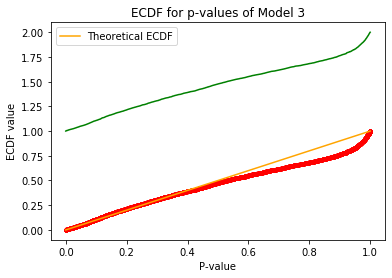

In [42]:
x1,y1 = ecdf(p_values2)
plt.plot(x1,y1+1, 'g-')
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2, 'r.')

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Marylebone

Different stations

In [186]:
sid = 45
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)

#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

In [187]:
thres = 0.4
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[45, 114, 182, 201, 605, 759, 760]


In [188]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

In [189]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -3.8937697 ,  -3.22549344, -12.62288785,   1.54832899],
       [ -3.84932703,  -3.19889454, -11.75186618,   1.30386401],
       [ -3.63966093,  -2.96654402, -11.09915976,   1.36434303],
       [ -3.69567122,  -2.92554209, -10.65684445,   1.46467096],
       [ -3.94910899,  -3.03065105, -10.79827322,   1.01576727]]), array([15862.41065476, 15865.35211356, 15884.19013374, 15896.60801416,
       15913.79061957]))
           fun: 15862.410654762522
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 800
           nit: 487
        status: 1
       success: False
             x: array([ -3.8937697 ,  -3.22549344, -12.62288785,   1.54832899])

In [190]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [191]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

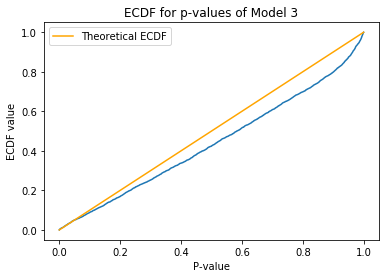

In [192]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Different stations with large k

In [193]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[-4.01397488, -7.75573055, -9.23922276],
       [-4.0139704 , -7.75581278, -9.23920537],
       [-4.01397024, -7.75572847, -9.2392063 ],
       [-4.01397267, -7.75572574, -9.23919636]]), array([16080.9818064 , 16080.98180641, 16080.98180641, 16080.98180642]))
           fun: 16080.98180639662
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 129
        status: 0
       success: True
             x: array([-4.01397488, -7.75573055, -9.23922276])

In [194]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

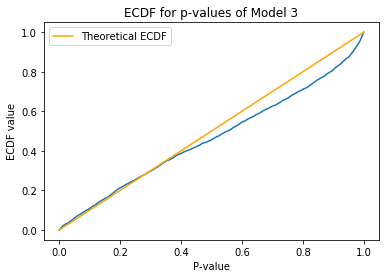

In [195]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Hawkes

In [196]:
t0 = train_times[45]
t1 = test_times[45]

In [197]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-4.01397488, -7.75573055, -9.23922276],
       [-4.0139704 , -7.75581278, -9.23920537],
       [-4.01397024, -7.75572847, -9.2392063 ],
       [-4.01397267, -7.75572574, -9.23919636]]), array([16080.9818064 , 16080.98180641, 16080.98180641, 16080.98180642]))
           fun: 16080.98180639662
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 129
        status: 0
       success: True
             x: array([-4.01397488, -7.75573055, -9.23922276])

In [198]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [199]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

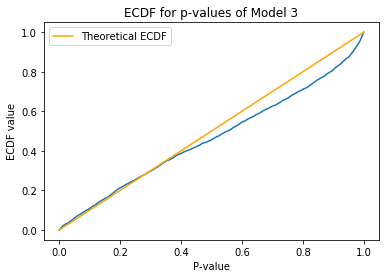

In [200]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [205]:
train_diff = np.array(ks_train_hawkes) - np.array(ks_train_spatio)
train_sign = np.sign(train_diff)
test_diff = np.array(ks_test_hawkes) - np.array(ks_test_spatio)
test_sign = np.sign(test_diff)

In [330]:
train_hawkes[50], train_spatio[50]

(0.07950922140832561, 0.08969871474433277)

In [206]:
train_sign

array([ 1., -1.,  1., -1.,  1., -1.])

In [207]:
test_sign

array([ 1., -1.,  1., -1.,  1., -1.])

In [211]:
def binomial(n, p, x):
    return math.comb(n, x)*(p**x)*((1-p)**(n-x))

In [213]:
ks_train_hawkes

[0.13008816003076396,
 0.10958350107443615,
 0.09854808464307341,
 0.10958350107443615,
 0.1634133831466098,
 0.09448922058279852]

In [214]:
ks_train_spatio

[0.09007596319086342,
 0.1118003314519328,
 0.08825365374535277,
 0.1389063069659825,
 0.15840584735505636,
 0.10645240256933808]

In [11]:
thres = 0.5
null_list = []
for k in range(808):
    sid = loc_codes[k] 
    ind = get_station_index(loc_codes, sid)
    
    if len(train_times[sid]) != 0:
        t0, ind_list = process_times(loc_codes, train_times, sid)
        t1, ind_list = process_times(loc_codes, test_times, sid)
    
    dist_arr = geo_df[f"{ind}"].to_numpy()
    new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
    if len(new_loc) < 2:
        null_list.append(sid)
null_list

[554, 692, 783, 844]

In [12]:
sid=4
ind = get_station_index(loc_codes, sid)
t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()
df = pd.DataFrame({'col1': list(dist_arr), 'col2': list(loc_codes)})
df=df.sort_values(by=['col1'])
ser = df.iloc[:, 0]
i = ser.searchsorted(1.2, side='right')
df1 = df.iloc[:i]

In [13]:
def thres_fun_new(dist, thres, loc_codes):
    new_dist = dist.copy()
    new_loc_codes = np.asarray(loc_codes).copy()
    df = pd.DataFrame({'col1': list(new_dist), 'col2': list(new_loc_codes)})
    df = df.sort_values(by=['col1'])
    
    df = pd.DataFrame({'col1': list(dist_arr), 'col2': list(loc_codes)})
    df=df.sort_values(by=['col1'])
    ser = df.iloc[:, 0]
    i = ser.searchsorted(thres, side='right')
    df1 = df.iloc[:i]
    
    return np.asarray(df1.iloc[:, 0]), np.asarray(df1.iloc[:, 1])

In [14]:
loc_list = np.array([  4,   5,  32,  37,  40,  42,  64,  95, 110, 111, 123, 125, 128,
       142, 150, 152, 163, 178, 180, 186, 188, 206, 207, 210, 211, 227,
       231, 239, 258, 259, 266, 272, 274, 291, 292, 296, 300, 309, 312,
       321, 322, 333, 339, 371, 387, 405, 409, 423, 432, 445, 449, 463,
       472, 483, 484, 486, 489, 502, 510, 512, 520, 528, 530, 531, 535,
       544, 558, 561, 593, 597, 600, 602, 610, 612, 615, 627, 632, 637,
       639, 641, 677, 679, 686, 687, 701, 711, 729, 734, 735, 739, 745,
       750, 777, 782, 790, 810, 811, 812, 821, 833])

In [16]:
max_t1 = 0
for i in loc_list:
    max_t1 = max(len(train_times[i]), max_t1)

max_t2 = 0
for i in loc_list:
    max_t2 = max(len(test_times[i]), max_t2)

In [ ]:
#loc_list = []
thres = 0.5
train_hawkes = []
test_hawkes = []
train_spatio = []
test_spatio = []

p0 = np.zeros((max_t_dep+1, 2))
p1 = np.zeros((max_t_dep+1, 2))
p2 = np.zeros((max_t_dep+1, 2))
p3 = np.zeros((max_t_dep+1, 2))

#while len(loc_list) < 100: 
for i in range(100): 
    #sid = np.random.choice(loc_codes)
    sid = loc_list[i]
    if len(train_times[sid]) != 0 and sid not in null_list: #and sid not in loc_list:
        #loc_list.append(sid)
        #print(len(loc_list))
        print(i)
        ind = get_station_index(loc_codes, sid)

        t0, ind_list = process_times(loc_codes, train_times, sid)
        t1, ind_list = process_times(loc_codes, test_times, sid)
    
        dist_arr = geo_df[f"{ind}"].to_numpy()
    
        new_dist, new_loc = thres_fun_new(dist_arr, thres, loc_codes)
    
        new_dist = new_dist
        new_loc = new_loc
    
        t00 = {}
        t01 = {}

        for loc in new_loc:
            if loc not in ind_list:
                t00[loc] = t0[loc]
                t01[loc] = t1[loc]
    
        new_loc = list(t00.keys())
        op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
        mle0 = op.minimize(op_diff_log_likelihood, x0 = [-4, -3, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
    
        beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

        t_dep = t00[sid]
        compensator_t0 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

        inter_arr_times0 = np.diff(compensator_t0)
        p_values0 = np.exp(-inter_arr_times0)
        ks0 = st.kstest(p_values0, "uniform")
        train_spatio.append(ks0.statistic)
        p0[0:len(t_dep), 0], p0[0:len(t_dep), 1] = ecdf(p_values0)[0], ecdf(p_values0)[1]
               
        beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])
 
        t_dep = t01[sid]
        compensator_t01 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

        inter_arr_times01 = np.diff(compensator_t01)
        p_values01 = np.exp(-inter_arr_times01)
        ks1 = st.kstest(p_values01, "uniform")
        test_spatio.append(ks1.statistic)
        
        p1[0:len(t_dep), 0], p1[0:len(t_dep), 1] = ecdf(p_values01)[0], ecdf(p_values01)[1]
        
        t0 = train_times[sid]
        t1 = test_times[sid]
        op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
        mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
        beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

        compensator_t2 = np.zeros(len(t0)+1)
        for i in range(len(t0)):
            compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

        inter_arr_times2 = np.diff(compensator_t2)
        p_values2 = np.exp(-inter_arr_times2)
        ks2 = st.kstest(p_values2, "uniform")
        train_hawkes.append(ks2.statistic)
        p2[0:len(t0), 0], p0[0:len(t0), 1] = ecdf(p_values2)[0], ecdf(p_values2)[1]
    
        beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

        compensator_t21 = np.zeros(len(t1)+1)
        for i in range(len(t1)):
            compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

        inter_arr_times21 = np.diff(compensator_t21)
        p_values21 = np.exp(-inter_arr_times21)
        ks21 = st.kstest(p_values21, "uniform")
        test_hawkes.append(ks21.statistic)

        p3[0:len(t1), 0], p1[0:len(t1), 1] = ecdf(p_values21)[0], ecdf(p_values21)[1]

In [18]:
#loc_list = []
thres = 0.5
train_hawkes = []
test_hawkes = []
train_spatio = []
test_spatio = []

p0 = np.zeros((max_t1+1, 100))
p1 = np.zeros((max_t2+1, 100))
p2 = np.zeros((max_t1+1, 100))
p3 = np.zeros((max_t2+1, 100))

#while len(loc_list) < 100: 
for i in range(100): 
    #sid = np.random.choice(loc_codes)
    sid = loc_list[i]
    if len(train_times[sid]) != 0 and sid not in null_list: #and sid not in loc_list:
        #loc_list.append(sid)
        #print(len(loc_list))
        print(i)
        ind = get_station_index(loc_codes, sid)

        t0, ind_list = process_times(loc_codes, train_times, sid)
        t1, ind_list = process_times(loc_codes, test_times, sid)
    
        dist_arr = geo_df[f"{ind}"].to_numpy()
    
        new_dist, new_loc = thres_fun_new(dist_arr, thres, loc_codes)
    
        new_dist = new_dist
        new_loc = new_loc
    
        t00 = {}
        t01 = {}

        for loc in new_loc:
            if loc not in ind_list:
                t00[loc] = t0[loc]
                t01[loc] = t1[loc]
    
        new_loc = list(t00.keys())
        op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
        mle0 = op.minimize(op_diff_log_likelihood, x0 = [-3.8, -3.1, -8.5, 1.7], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
    
        beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

        t_dep = t00[sid]
        compensator_t0 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

        inter_arr_times0 = np.diff(compensator_t0)
        p_values0 = np.exp(-inter_arr_times0)
        ks0 = st.kstest(p_values0, "uniform")
        train_spatio.append(ks0.statistic)
        print(ks0.statistic)
        p0[0:len(t_dep), i] = p_values0
               
        beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])
 
        t_dep = t01[sid]
        compensator_t01 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

        inter_arr_times01 = np.diff(compensator_t01)
        p_values01 = np.exp(-inter_arr_times01)
        ks1 = st.kstest(p_values01, "uniform")
        test_spatio.append(ks1.statistic)
        
        p1[0:len(t_dep), i] =  p_values01
        
        t0 = train_times[sid]
        t1 = test_times[sid]
        op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
        mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-4.1, -6.3, -6.1], method = 'Nelder-Mead', args=(t0,))
        beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

        compensator_t2 = np.zeros(len(t0)+1)
        for j in range(len(t0)):
            compensator_t2[j+1] = hawkes_comp(t0[j], t0, beta2, theta2, lambda_b2)

        inter_arr_times2 = np.diff(compensator_t2)
        p_values2 = np.exp(-inter_arr_times2)
        ks2 = st.kstest(p_values2, "uniform")
        train_hawkes.append(ks2.statistic)
        print(ks2.statistic)
        p2[0:len(t0), i] = p_values2
    
        beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

        compensator_t21 = np.zeros(len(t1)+1)
        for j in range(len(t1)):
            compensator_t21[j+1] = hawkes_comp(t1[j], t1, beta2, theta2, lambda_b2)

        inter_arr_times21 = np.diff(compensator_t21)
        p_values21 = np.exp(-inter_arr_times21)
        ks21 = st.kstest(p_values21, "uniform")
        test_hawkes.append(ks21.statistic)

        p3[0:len(t1), i] = p_values21

0
0.12628891744955173
0.13936883226660368
1
0.07563973293888882
0.07749609575566174
2
0.07433120074472732
0.09034179254274743
3
0.0742730314577359
0.07651879129644834
4
0.10784562009123455
0.12148190884931809
5
0.06206923915544049
0.06621537828483515
6
0.10967550343118992
0.1434944589301238
7
0.07661046013643791
0.0799049369223298
8
0.07360905795172168
0.07408022129600678
9
0.11033154733300177
0.12020297327253826
10
0.08034223054780754
0.09020168338724
11
0.10202252179393745
0.10872418114070448
12
0.0781473619711004
0.08151720739406965
13
0.08580726457100862
0.08754412278094192
14
0.10620133598430037
0.11568752999597742
15
0.07398796803225571
0.07686783729380176
16
0.06309787770467312
0.06850292240101075
17
0.06255559255282761
0.06588856932799858
18
0.09652319956649513
0.11163472110541262
19
0.08150611829787313
0.08831590104341647
20
0.13852979070144422
0.14617974877751938
21
0.09714040979359195
0.09700500518632882
22
0.10232212608482372
0.14257381250113277
23
0.08481110630022703
0.092

In [45]:
np.mean(train_hawkes)

0.10145383603559355

7 parameters model compared with mutual model
100 stations picked at random: threshold distance/5 stations around it, repeat and compare ks scores, sign test
capacity at stations
initial parameters
compare train and test ks scores for robustness of model

In [20]:
train_diff = np.array(train_hawkes) - np.array(train_spatio)
train_sign = np.sign(train_diff)
test_diff = np.array(test_hawkes) - np.array(test_spatio)
test_sign = np.sign(test_diff)

In [21]:
from collections import Counter
Counter(train_sign)

Counter({1.0: 91, -1.0: 9})

In [22]:
from collections import Counter
Counter(test_sign)

Counter({1.0: 82, -1.0: 18})

In [55]:
rel_train_ks = (np.array(train_hawkes) - np.array(train_spatio)) / np.array(train_hawkes)
#uni_rel_train_ks = np.unique(rel_train_ks)
rel_test_ks = (np.array(test_hawkes) - np.array(test_spatio)) / np.array(test_hawkes)
#uni_rel_test_ks = np.unique(rel_test_ks)

We now want to plot the scatter plot of station coordinates of the randomly selected 100 stations, labelling the points by the difference in their ks scores.

In [56]:
len(train_hawkes)

100

In [57]:
station_data = pd.read_csv("./santander_locations.csv")

In [58]:
#uni_loc_list = np.unique(np.array(loc_list))
d = {'loc': loc_list, 'train': rel_train_ks, 'test': rel_test_ks}
df1 = pd.DataFrame(data=d)
df1 = df1.sort_values(by=['loc'])
df1 = df1.drop_duplicates(subset=['loc'])

In [59]:
df1

,loc,train,test
0,4,0.093851,0.099162
1,5,0.023954,0.073944
2,32,0.177222,0.156144
3,37,0.029349,0.124952
4,40,0.112250,0.098970
...,...,...,...
95,810,0.116520,0.096586
96,811,0.086753,0.063796
97,812,-0.026541,-0.044596
98,821,0.007930,0.051530


In [60]:
mask = station_data['Station.Id'].isin(loc_list)
df = station_data.loc[mask]
df['train.ks'] = list(df1['train'])
df['test.ks'] = list(df1['test'])
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Station.Id,StationName,longitude,latitude,Easting,Northing,train.ks,test.ks
3,4,"St. Chad's Street, King's Cross",-0.120974,51.530100,530436.760,182911.990,0.093851,0.099162
4,5,"Sedding Street, Sloane Square",-0.156876,51.493100,528051.649,178742.097,0.023954,0.073944
31,32,"Leonard Circus, Shoreditch",-0.084439,51.524700,532986.420,182381.310,0.177222,0.156144
35,37,"Penywern Road, Earl's Court",-0.192369,51.491600,525590.340,178509.690,0.029349,0.124952
38,40,"Commercial Street, Shoreditch",-0.075579,51.521300,533611.070,182016.510,0.112250,0.098970
...,...,...,...,...,...,...,...,...
778,810,"Tate Modern, Bankside",-0.098885,51.506721,532037.270,180356.310,0.116520,0.096586
779,811,"Westferry Circus, Canary Wharf",-0.027776,51.505697,536975.000,180373.000,0.086753,0.063796
780,812,"Here East North, Queen Elizabeth Olympic Park",-0.022627,51.548724,537203.027,185167.369,-0.026541,-0.044596
789,821,"Battersea Power Station, Battersea Park",-0.147702,51.483516,528714.824,177688.956,0.007930,0.051530


In [61]:
max(list(df['train.ks']))

0.2823217371422206

In [62]:
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
cols = np.array(cmap((df['train.ks'] + max(np.abs(df['train.ks']))) / (2 * max(np.abs(df['train.ks'])))))[:,:3]

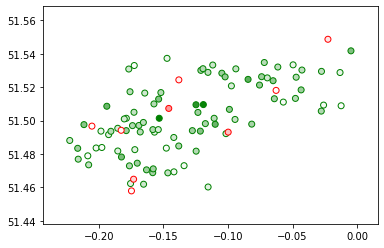

In [70]:
import seaborn as sns
edges = np.array(['red','green'])[np.array(df['train.ks'] > 0).astype(int)]
plt.scatter(df['longitude'], df['latitude'], c=cols, edgecolor = edges)
plt.savefig('fig2.pdf')

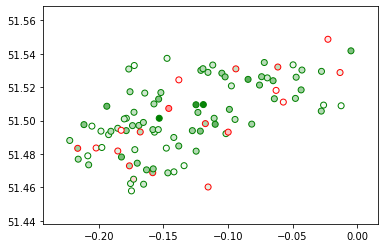

In [71]:
edges = np.array(['red','green'])[np.array(df['test.ks'] > 0).astype(int)]
plt.scatter(df['longitude'], df['latitude'], c=cols, edgecolor = edges)
plt.savefig('fig1.pdf')

We plot the ks scores of each station over the log of the number of departure events at each station. 

In [61]:
dep_len_train_all = []
dep_len_test_all = []
dep_len_train_id = []
dep_len_test_id = []

for i in range(len(loc_list)):
    sid = loc_list[i]
    ind = get_station_index(loc_codes, sid)
    train_len = 0
    test_len = 0
    
    t0, ind_list = process_times(loc_codes, train_times, sid)
    t1, ind_list = process_times(loc_codes, test_times, sid)
    
    dist_arr = geo_df[f"{ind}"].to_numpy()
    
    new_dist, new_loc = thres_fun_new(dist_arr, thres, loc_codes)
    
    new_dist = new_dist
    new_loc = new_loc
    
    t00 = {}
    t01 = {}

    for loc in new_loc:
        if loc not in ind_list:
            t00[loc] = t0[loc]
            train_len += len(t00[loc])
            t01[loc] = t1[loc]
            test_len += len(t01[loc])

    dep_len_train_all.append(train_len)
    dep_len_test_all.append(test_len)

    dep_len_train_id.append(len(t00[sid]))
    dep_len_test_id.append(len(t01[sid]))
    
log_dep_train_all = np.log(np.array(dep_len_train_all))
log_dep_test_all = np.log(np.array(dep_len_test_all))
    
log_dep_train = np.log(np.array(dep_len_train_id))
log_dep_test = np.log(np.array(dep_len_test_id))

In [62]:
d1 = {'loc': loc_list, 'train.ks': rel_train_ks, 
      'test.ks': rel_test_ks, 'train.len.all': log_dep_train_all, 
      'test.len.all': log_dep_test_all, 'train.len.id': log_dep_train, 'test.len.id': log_dep_test}
df2 = pd.DataFrame(data=d1)
df2 = df2.sort_values(by=['loc'])
df2 = df2.drop_duplicates(subset=['loc'])

In [63]:
df2

,loc,train.ks,test.ks,train.len.all,test.len.all,train.len.id,test.len.id
0,4,0.093851,0.099162,10.306282,9.198875,7.517521,6.434547
1,5,0.023954,0.073944,9.805654,8.747511,8.716536,7.610853
2,32,0.177222,0.156144,10.624128,9.492733,8.494743,7.346655
3,37,0.029349,0.124952,10.189531,9.093245,8.358197,7.195937
4,40,0.112250,0.098970,10.859114,9.734359,8.242493,7.065613
...,...,...,...,...,...,...,...
95,810,0.116520,0.096586,10.142308,9.063926,7.989899,6.978214
96,811,0.086753,0.063796,9.718903,8.585599,8.780480,7.631432
97,812,-0.026541,-0.044596,9.241548,8.013343,7.959276,6.776507
98,821,0.007930,0.051530,10.011759,8.992682,9.314070,8.195058


Scatter plot of all departure training events in the neighborhood of each station.

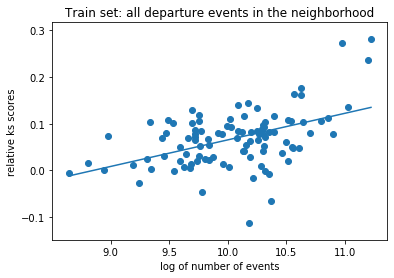

In [64]:
#sns.scatterplot('train.len', 'train.ks', data=df, hue=df['train.ks'])
x = df2['train.len.all']
y = df2['train.ks']
plt.scatter(x, y)

#a, b = np.polyfit(x, y, 1)
#plt.plot(x, a*x+b)        
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: all departure events in the neighborhood')
plt.show()

In [65]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.0028029374564714107

Scatter plot of the departure train events of each station only.

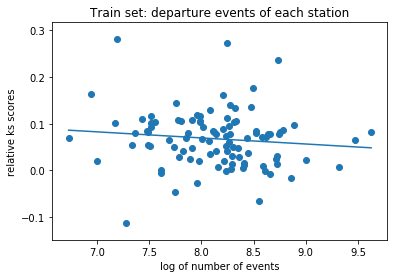

In [66]:
x = df2['train.len.id']
y = df2['train.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: departure events of each station')
plt.show()

In [67]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.003567819116805698

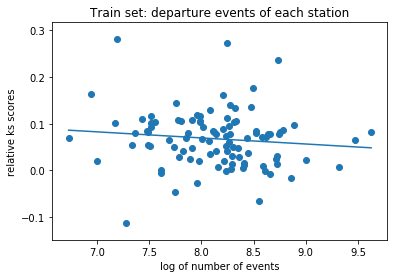

In [68]:
#Remove anomalies
indice = np.where(y.to_numpy() < 0.4)[0].tolist()
x_new = x.to_numpy()[indice]
y_new = y.to_numpy()[indice]
plt.scatter(x_new, y_new)
plt.plot(np.unique(x_new), np.poly1d(np.polyfit(x_new, y_new, 1))(np.unique(x_new)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: departure events of each station')
plt.show()

Scatter plot of all departure test events in the neighbourhood of each station.

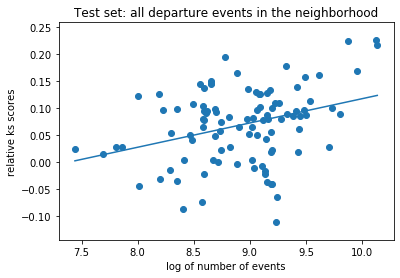

In [69]:
#sns.scatterplot('longitude', 'latitude', data=df, hue=df['test.ks'])
x = df2['test.len.all']
y = df2['test.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: all departure events in the neighborhood')
plt.show()

In [70]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.004201597710507084

Scatter plot of the departure test events of each station only.

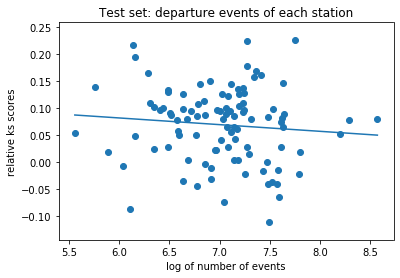

In [71]:
x = df2['test.len.id']
y = df2['test.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: departure events of each station')
plt.show()

In [72]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.0046839044728461555

In [73]:
indice = np.argwhere(train_sign == 1).tolist()
len(indice)

success_list = []
for i in indice:
    success_list.append(loc_list[i[0]])

In [74]:
indice1 = np.argwhere(test_sign == 1).tolist()
len(indice1)

success_list1 = []
for i in indice:
    success_list1.append(loc_list[i[0]])

In [75]:
from collections import Counter
Counter(train_sign)

Counter({1.0: 91, -1.0: 9})

1.literature review: bike sharing systems, hawkes processes

2.Theory

3.4 models: hawkes at one station vs different stations, arrival and departure at one station vs at different stations

4.Simulations: how well the parameters are recovered, histograms 

5. Compare KS scores for chosen stations with improvements for the two pairs. Check relationships of KS scores with popularity and geographical locations

6.Train and test set for robustness

7. Different distance kappa functions

simulation for spatio component
github link

In [47]:
train_mutual = [0.04740251820339503,
 0.024410820208493,
 0.027553622447433923,
 0.02471941899834129,
 0.03750619803724692,
 0.02726503349543896,
 0.03378463227122447,
 0.025124852455066626,
 0.028048537934086126,
 0.021114765437649008,
 0.046459322629264777,
 0.03832431078205484,
 0.03901496332302118,
 0.0522268347317445,
 0.035236662147186626,
 0.029555973463390228,
 0.020439183746368883,
 0.03375179778827919,
 0.03389474004119919,
 0.03548638692103834,
 0.05610937231054741,
 0.028338980231369326,
 0.05123126331822436,
 0.03017214006931157,
 0.04556852731474498,
 0.038020096775446266,
 0.046557450960132585,
 0.023136986853065034,
 0.04605427008999158,
 0.0433563677124047,
 0.04815715023834444,
 0.0317311936776869,
 0.02860736852256962,
 0.046509644659597005,
 0.029456279681479902,
 0.03245345367605268,
 0.024881758082763827,
 0.04833301557461972,
 0.02683898452306821,
 0.03007480756110359,
 0.033501904059150545,
 0.029271410691736444,
 0.04956084430579055,
 0.044985074880505294,
 0.03593095535381419,
 0.02754037946122523,
 0.031870781485305644,
 0.04807357386103239,
 0.05455888358515054,
 0.04048618447238839,
 0.039262197872744486,
 0.06023087039056485,
 0.060579929613615024,
 0.04312573582375612,
 0.04748138764396592,
 0.03149631476597364,
 0.034352668372952644,
 0.022608753119821468,
 0.03408329048805214,
 0.02042364247494005,
 0.03791026766071104,
 0.04540072315910776,
 0.05704657377876665,
 0.03344195915725717,
 0.04501662701947695,
 0.04052155250911549,
 0.02415444068215067,
 0.03931182737300942,
 0.058021533051177854,
 0.033903148031608876,
 0.03144018098371015,
 0.03315045249439652,
 0.04168654695924362,
 0.03130181932718423,
 0.03831920668297073,
 0.054697581079388935,
 0.029133876380464607,
 0.0360902315636753,
 0.025217858131388216,
 0.042951430838461147,
 0.05230811876336566,
 0.028424626205579506,
 0.03546202573374224,
 0.029484622264027704,
 0.0300392912623757,
 0.04202583028948437,
 0.05286127135008167,
 0.04769409762438925,
 0.0404345284583838,
 0.04097230992820722,
 0.038051047948123584,
 0.053443459035175556,
 0.056489885369455206,
 0.030391601052719874,
 0.052866603819434865,
 0.04990078016222632,
 0.04417201192389969,
 0.04652731307783359,
 0.023576102396511978,
 0.03840841144307128]

In [48]:
train_seven = [0.031407416935973986,
 0.019833771730824623,
 0.02109951763788326,
 0.01901680827980362,
 0.02239687184201372,
 0.023736537907607824,
 0.024760541268071423,
 0.028432348127588325,
 0.0220506770638228,
 0.02114890174439016,
 0.0268202151997331,
 0.023405895797027565,
 0.036500467782988044,
 0.0287849880204889,
 0.020787373791148367,
 0.030203230368015477,
 0.01634901905248881,
 0.02311533995412457,
 0.03186170969836383,
 0.030054628271245498,
 0.033116927739131,
 0.016317979134524152,
 0.040556951014427356,
 0.018863629950990446,
 0.048316993625634796,
 0.018816594812841536,
 0.053756870788546296,
 0.019365454635953905,
 0.053166913764084445,
 0.035467856655670205,
 0.036340410774251874,
 0.014651758688205008,
 0.024573233628827684,
 0.029132476189725975,
 0.024650568247040927,
 0.02368615006012259,
 0.04202080132206709,
 0.030116924464884842,
 0.029729451113388428,
 0.02724846757281507,
 0.015579279878440266,
 0.037893693981361776,
 0.031264372551274344,
 0.03906773909622541,
 0.020455244114254922,
 0.01959439896798626,
 0.03108108946074073,
 0.027487526059758127,
 0.046789107303434996,
 0.028396744332783774,
 0.02425868951500293,
 0.044294146235272835,
 0.03573335013434398,
 0.028234447509204563,
 0.02765772490222007,
 0.026912398218547406,
 0.03171176870045911,
 0.01998084900867414,
 0.030511768459167754,
 0.022927198117046133,
 0.03125953827423822,
 0.056273702108919355,
 0.041226341358878316,
 0.02954195804142573,
 0.03760098195551931,
 0.021008387720501287,
 0.018378204938451825,
 0.03203802001641487,
 0.0328968343281435,
 0.021487635145185202,
 0.02249929176513732,
 0.02929517866401632,
 0.017637036737416456,
 0.03172143819506201,
 0.035601107835300905,
 0.042610875260996495,
 0.02682957464317226,
 0.035553931229727886,
 0.020942962827480094,
 0.03334497762333449,
 0.030623568828270886,
 0.026813279824526193,
 0.0230885459036253,
 0.03069948270868006,
 0.024182492133826172,
 0.028092354672669795,
 0.038136108360704246,
 0.029541363386023534,
 0.012716253795661991,
 0.02783786412215694,
 0.034805840856931614,
 0.027343964161972267,
 0.03974871877624764,
 0.03217938841289697,
 0.045243841049926736,
 0.04168480773939287,
 0.03157162652811141,
 0.09696723195444101,
 0.02207646986349282,
 0.024137163513281656]

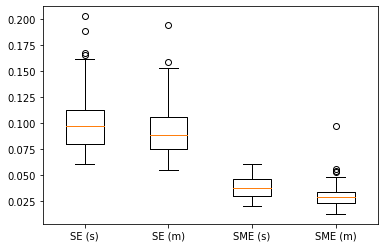

In [52]:
data = [train_hawkes, train_spatio, train_mutual, train_seven]
plt.boxplot(data)

plt.xticks([1, 2, 3, 4], ['SE (s)', 'SE (m)', 'SME (s)', 'SME (m)'])
plt.savefig('box.pdf')

In [50]:
np.mean(train_diff)

0.007300636621984193

In [51]:
train_diff

array([ 1.30799148e-02,  1.85636282e-03,  1.60105918e-02,  2.24575984e-03,
        1.36362888e-02,  4.14613913e-03,  3.38189555e-02,  3.29447679e-03,
        4.71163344e-04,  9.87142594e-03,  9.85945284e-03,  6.70165935e-03,
        3.36984542e-03,  1.73685821e-03,  9.48619401e-03,  2.87986926e-03,
        5.40504470e-03,  3.33297678e-03,  1.51115215e-02,  6.80978275e-03,
        7.64995808e-03, -1.35404607e-04,  4.02516864e-02,  7.35411125e-03,
        8.79426300e-03,  6.82736889e-03,  1.25694750e-02, -1.14891372e-03,
        3.30425965e-03,  7.49362665e-03,  7.53520015e-03,  7.99748873e-03,
       -3.08130656e-05,  8.89139868e-03,  8.03198448e-03,  6.11987011e-03,
        8.08904802e-03,  5.53380393e-02,  4.10425105e-03,  6.37242438e-03,
        9.19707805e-03,  1.66311768e-02,  4.79952451e-03,  1.84131514e-02,
        1.91467460e-02, -5.74332218e-04, -6.74071702e-03,  4.41751929e-03,
        1.40440567e-02,  1.13850729e-02,  9.11821276e-04,  6.41831120e-03,
        7.64564455e-03,  